In [22]:
#Load some packages to be used in this program
import matplotlib as plt
import scipy  as sp
import numpy  as np
import xarray as xr
import pyart  as pyart
import os
import glob
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy as cartopy
%pylab inline
import cartopy.io.shapereader as shpreader
import netCDF4  as netCDF4
import pytz

from matplotlib.animation import FuncAnimation
#import matplotlib.animation as animation

Populating the interactive namespace from numpy and matplotlib


/home/sransom/.conda/envs/clouds_env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time', 'title', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
#load sample data file for instructive usage
radar = pyart.io.read('/nfs/gce/projects/digr/xsapr_nsa/BRW190120002403.RAWTA32.maint')
rlon = -radar.longitude['data'][0]
rlat = radar.latitude['data'][0]

In [3]:
# Read all files of
jan_20_evening = glob.glob('/nfs/gce/projects/digr/xsapr_nsa/BRW1901202*')
jan_20_evening.sort()

In [4]:
#Get the date at the start of collection
index_at_start = radar.sweep_start_ray_index['data'][0]
time_at_start_of_radar = pyart.io.cfradial.netCDF4.num2date(radar.time['data'][index_at_start], 
                                  radar.time['units'])

#make a nice time stamp
pacific = pytz.timezone('US/Alaska')
local_time = pacific.fromutc(time_at_start_of_radar)
fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
print('fancy date string: ' + fancy_date_string)

#Give it a nice title
title = 'X-SAPR Utqiagvik \n' + fancy_date_string

fancy date string: Saturday January 19 at 03:24 PM AKST


Now we will grid the data:

In [5]:
radar.fields.keys()

dict_keys(['total_power', 'reflectivity', 'velocity', 'spectrum_width', 'differential_reflectivity', 'specific_differential_phase', 'cross_correlation_ratio', 'normalized_coherent_power', 'differential_phase'])

In [6]:
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_above('total_power', 40)
gatefilter.exclude_below('total_power', 10)

In [7]:
#Grid the data and put into "radurr"
grid = pyart.map.grid_from_radars((radar,),
                                      (16,2000,2000), ((0,15000),(-20000, 20000), (-20000, 20000)),#(-lat_extent, lat_extent), (-lon_extent,lon_extent)),
                                      fields = radar.fields.keys(), weighting_function = 'Barnes2',
                                      gatefilter = (gatefilter,),
                                      gridding_algo='map_gates_to_grid')
    
grid_path = '/home/sransom/pyth/grid_eg.nc'
    
grid.write(grid_path)
    
del grid
    
    
radurr = pyart.io.read_grid(grid_path)

In [8]:
print(radurr.fields['total_power']['units'])

dBZ


In [9]:
lon, lat = radurr.get_point_longitude_latitude()
height = radurr.point_z['data'][:,0,0]
time = np.array([ netCDF4.num2date(radurr.time['data'][0], radurr.time['units'])])

In [10]:
#Define function to make xr arrays out of gridded data
ds = xr.Dataset()
def gridmake(field, time):
    this_data = radurr.fields[field]['data']
    this_data = np.ma.filled(this_data, np.nan)
    my_data = xr.DataArray(np.expand_dims(this_data,0),
                              dims = ('time', 'z', 'y', 'x'),
                              coords = {'time' : (['time'], time),
                                        'z' : (['z'], height),
                                        'lat' :(['y','x'], lat),
                                        'lon' : (['y','x'],lon),
                                         'y' : (['y'],lat[:,0]),
                                         'x' : (['x'],lon[0,:])})
    for this_meta in list(radurr.fields[field].keys()):
        if this_meta is not 'data':
            my_data.attrs.update({this_meta: radurr.fields[field][this_meta]})
    ds[field] = my_data
    ds.lon.attrs = [('long_name', 'longitude of grid cell center'),
            ('units', 'degrees_east')]
    ds.lat.attrs = [('long_name', 'latitude of grid cell center'),
            ('units', 'degrees_north')]
    ds.z.attrs['long_name'] = field
    ds.z.attrs['units'] = radurr.fields[field]['units']
    ds.z.encoding['_FillValue'] = -9999.0
    ds.lat.encoding['_FillValue'] = -9999.0
    ds.lon.encoding['_FillValue'] = -9999.0
    return ds
    
    
#for this_field in list(radurr.fields.keys()):



In [11]:
#Add fields to ds
for field in radurr.fields.keys():
    gridmake(field, time)
print("ds:")
print(ds)

ds:
<xarray.Dataset>
Dimensions:                      (time: 1, x: 2000, y: 2000, z: 16)
Coordinates:
  * time                         (time) datetime64[ns] 2019-01-20T00:24:19.267000
  * z                            (z) float64 0.0 1e+03 2e+03 ... 1.4e+04 1.5e+04
    lat                          (y, x) float64 71.14 71.14 71.14 ... 71.5 71.5
    lon                          (y, x) float64 -157.2 -157.2 ... -156.1 -156.1
  * y                            (y) float64 71.14 71.14 71.14 ... 71.5 71.5
  * x                            (x) float64 -157.2 -157.2 ... -156.1 -156.1
Data variables:
    total_power                  (time, z, y, x) float32 -7.337628 ... -6.9793415
    reflectivity                 (time, z, y, x) float32 -7.396243 ... -7.450837
    velocity                     (time, z, y, x) float32 -1.0932289 ... 0.36164117
    spectrum_width               (time, z, y, x) float32 0.7943922 ... 1.3049043
    differential_reflectivity    (time, z, y, x) float32 6.371385 ... 7.775479

In [19]:
#Load shapefile 
coastline = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_1_states_provinces')

In [23]:
coastline = cartopy.feature.NaturalEarthFeature(category='cultural',
                              name='admin_0_boundary_lines_land',
                              scale='50m', facecolor='none')

In [31]:
print(ds.total_power[0].sel.__doc__)

Return a new DataArray whose dataset is given by selecting
        index labels along the specified dimension(s).

        .. warning::

          Do not try to assign values when using any of the indexing methods
          ``isel`` or ``sel``::

            da = xr.DataArray([0, 1, 2, 3], dims=['x'])
            # DO NOT do this
            da.isel(x=[0, 1, 2])[1] = -1

          Assigning values with the chained indexing using ``.sel`` or
          ``.isel`` fails silently.

        See Also
        --------
        Dataset.sel
        DataArray.isel

        


In [50]:
dir(my_ax.axes)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_autotitlepos',
 '_axes',
 '_axes_class',
 '_axes_locator',
 '_axisbelow',
 '_boundary',
 '_clipon',
 '_clippath',
 '_connected',
 '_contains',
 '_convert_dx',
 '_current_image',
 '_done_img_factory',
 '_facecolor',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_extent_geom',
 '_get_lines',
 '_get_patches_for_fill',
 '_get_view',
 '_gid',
 '_gridOn',
 '_gridliners',
 '_in_layout',
 '_init_axis',
 '_label',
 '_layoutbo

In [67]:
dir(my_ax)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_autotitlepos',
 '_axes',
 '_axes_class',
 '_axes_locator',
 '_axisbelow',
 '_boundary',
 '_clipon',
 '_clippath',
 '_connected',
 '_contains',
 '_convert_dx',
 '_current_image',
 '_done_img_factory',
 '_facecolor',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_extent_geom',
 '_get_lines',
 '_get_patches_for_fill',
 '_get_view',
 '_gid',
 '_gridOn',
 '_gridliners',
 '_in_layout',
 '_init_axis',
 '_label',
 '_layoutbo

<bound method GeoAxes.coastlines of <cartopy.mpl.geoaxes.GeoAxesSubplot object at 0x7fd99f141c18>>

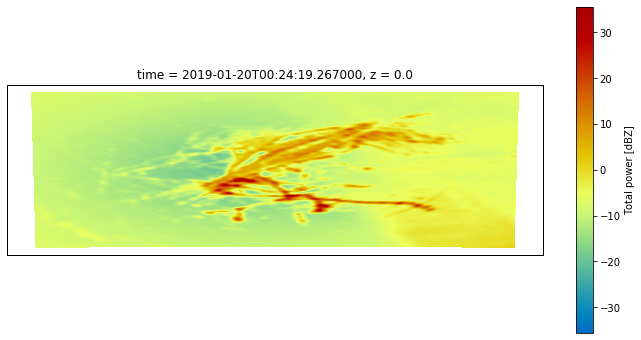

In [57]:
field = 'total_power'

fig = plt.figure(figsize = (12, 6))

my_ax = plt.subplot(projection = ccrs.Mercator())

pc = ds.total_power[0].sel(z=10, method='nearest').plot.pcolormesh(
    transform=ccrs.Mercator(),
    ax=my_ax,
    x='lon', y='lat',
    #vmin=0, vmax=70, 
    cmap=pyart.graph.cm_colorblind.HomeyerRainbow)

my_ax.coastlines


#my_ax.add_feature(coastline, linestyle = "-", edgecolor = "black")




/home/sransom/pyart/pyart/graph/gridmapdisplay_basemap.py:666: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  self.basemap = Basemap(**kwargs)
/home/sransom/.conda/envs/clouds_env/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4759: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if fix_wrap_around and itemindex:


AttributeError: 'QuadMesh' object has no property 'lat_lines'

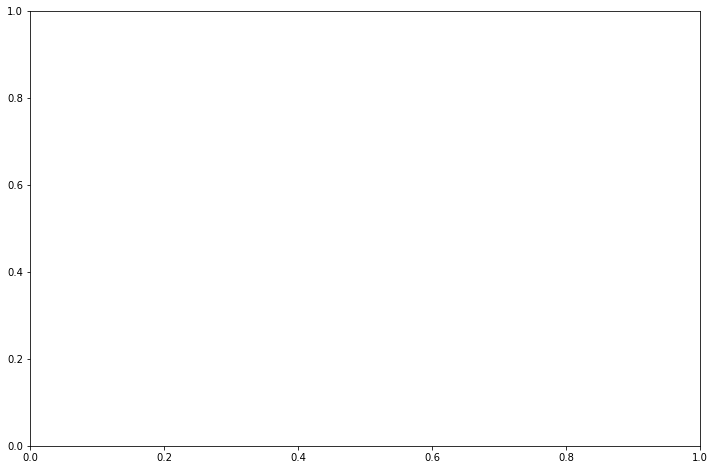

In [45]:
# create the plot
display = pyart.graph.GridMapDisplayBasemap(radurr)

fig = plt.figure(figsize = [12, 8])

min_lon = -157.1
max_lon = -156,
min_lat =  71.2
max_lat = 71.44,
lon_lines = np.arange(-157.15,-155.95,.15)
lat_lines = np.arange(71.17, 71.5, .03)

display.plot_grid('total_power', #fig=fig,
                  lat_lines=lat_lines,
                  lon_lines=lon_lines,
                  projection = ccrs.Mercator()
                 )

#display.plot_basemap(lat_lines=lat_lines, lon_lines=lon_lines,
                   #  auto_range = True)


#my_ax = fig.add_subplot(111,projection = ccrs.Mercator())

#my_ax.read_shapefile('shpfilename')




#display.plot_basemap(lat_lines=lat_lines, lon_lines=lon_lines,
#                     min_lon=min_lon, max_lon=max_lon,
#                     min_lat=min_lat, max_lat=max_lat)

#
##
##ax = plt.axes(projection = projection)
#ax = fig.add_subplot(111)
#ax.imshow(grid.fields['total_power']['data'], origin='lower')
#plt.show()
#plt.close()

In [26]:
print(fig.add_subplot.__doc__)

Add an `~.axes.Axes` to the figure as part of a subplot arrangement.

Call signatures::

   add_subplot(nrows, ncols, index, **kwargs)
   add_subplot(pos, **kwargs)
   add_subplot(ax)
   add_subplot()

Parameters
----------
*args
    Either a 3-digit integer or three separate integers
    describing the position of the subplot. If the three
    integers are *nrows*, *ncols*, and *index* in order, the
    subplot will take the *index* position on a grid with *nrows*
    rows and *ncols* columns. *index* starts at 1 in the upper left
    corner and increases to the right.

    *pos* is a three digit integer, where the first digit is the
    number of rows, the second the number of columns, and the third
    the index of the subplot. i.e. fig.add_subplot(235) is the same as
    fig.add_subplot(2, 3, 5). Note that all integers must be less than
    10 for this form to work.

    If no positional arguments are passed, defaults to (1, 1, 1).

    In rare circumstances, `.add_subplot` may be 

In [13]:
grid = pyart.map.grid_from_radars((radar,),
                                  (16,2000,2000), ((0,15000),(-20000, 20000), (-20000, 20000)),#(-lat_extent, lat_extent), (-lon_extent,lon_extent)),
                                  fields = ['total_power'], weighting_function = 'Barnes2',
                                  gatefilter = (gatefilter,),
                                  gridding_algo='map_gates_to_grid')

grid_path = '/home/sransom/pyth/grid_eg.nc'

grid.write(grid_path)

del grid


radurr = pyart.io.read_grid(grid_path)

In [15]:
np.ma.masked

masked

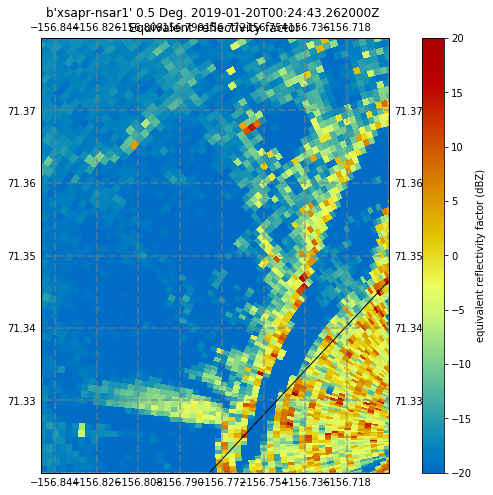

In [16]:



display    = pyart.graph.RadarMapDisplay(radar)
projection = ccrs.Mercator(central_longitude=rlon,
                           min_latitude=rlat-5.,
                           max_latitude=rlat+5.)
fig        = plt.figure(figsize = (12,8))


# Plot data for one day
display.plot_ppi_map('reflectivity', 1, 
                     vmin = -20,
                     vmax =  20,
                     min_lon = -156.85, max_lon = -156.7,
                     min_lat =  71.32, max_lat =  71.38,
                     resolution = '10m',
                     projection = projection,
                     # Add lines of lat and lon
                     lat_0=radar.latitude ['data'][0],
                     lon_0=radar.longitude['data'][0]
                    )
display.ax.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
# Add point demarkating location of xsapr  site
display.plot_point(radar.longitude['data'][0], radar.latitude['data'][0], color = 'k')

plt.show()

In [ ]:
dir(radar)
# ang1 = sample.fixed_angle['data'][0]

In [ ]:
# Create gate filter that isolates velocities characteristic of sea ice

gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_above('total_power', 40)
gatefilter.exclude_below('total_power', 20)


In [ ]:
anim_klot = FuncAnimation(fig, animate, fargs = ('total_power', vmin, vmax,), frames=len(jan_20_evening))
    anim_klot.save('/home/sransom/pyth/gatefilter_eg.gif', writer = 'imagemagick', fps=2)
    #plt.show()
    plt.close()